The neural style
transfer algorithm was first presented in the following article by Gatys et al.: A Neural
Algorithm of Artistic Style ( https:/​ / ​ arxiv.​ org/​ abs/​ 1508.​ 06576 ).

In neural style transfer, we take a content image and a style image. Then, we generate an image to have the content of the content image and the artistic sytle of the style image.

# Loading the data

In this recipe, we will first load the content and style images as PIL objects. Then, we will transform the PIL objects to PyTorch tensors so that we can feed them into the model. Then, we will display the tensors. Then, we will display the tensors.

## Getting ready

You can use the images provided with the scripts of this chapter or use any other images of your own. If you chose the latter, rename your images to content.jpg and style.jpg.

### 1. Load the content and style images:

In [1]:
from PIL import Image
path2content = "./data/content.png"
path2sytle = "./data/style.png"

content_img = Image.open(path2content).convert('RGB')
style_img = Image.open(path2sytle)

In [2]:
style_img.mode

'RGB'

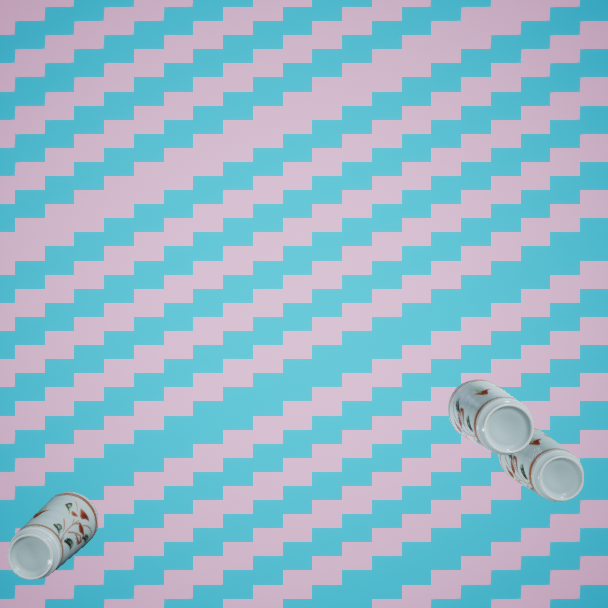

In [3]:
# display the content image
content_img

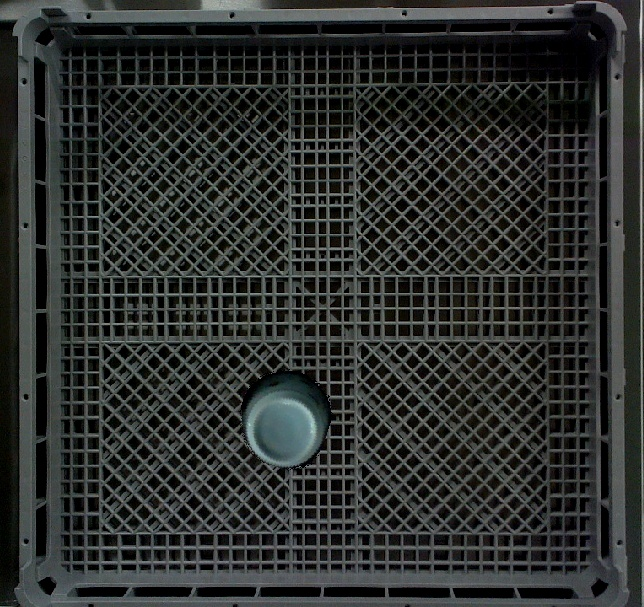

In [4]:
style_img

### 2. Define the transformation as follows:

In [5]:
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb)])

### 3. Transform the PIL images to tensors:

In [6]:
# pass the content image to transformer
content_tensor = transformer(content_img)
print(content_tensor.shape, content_tensor.requires_grad)

torch.Size([3, 256, 384]) False


In [7]:
# pass the style image to transformer
style_tensor = transformer(style_img)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False


### 4. Display the content image after transformation:

In [8]:
# first define a helper function to convert to back tensors
# to PIL images
import torch

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1, 1)
    img_tensor_c += torch.tensor(mean_rgb).view(3, 1, 1)
    img_tensor_c = img_tensor_c.clamp(0, 1)
    img_pil = to_pil_image(img_tensor_c)
    
    return img_pil

Text(0.5, 1.0, 'content image')

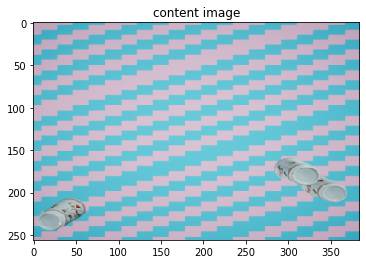

In [9]:
# then, call the helper function to display content tensor
import matplotlib.pylab as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image

plt.imshow(imgtensor2pil(content_tensor))
plt.title("content image")

Text(0.5, 1.0, 'style image')

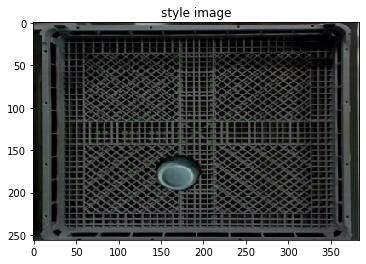

In [10]:
# Next display style tensor
plt.imshow(imgtensor2pil(style_tensor))
plt.title("style image")

## Implementing neural style transfer

Usually we load the input and target data, define a model, an objective function and optimizer, and then train the model by updating the model parameters using the gradient-descent algorithm. In all of these past cases, the input to the model was kept unchanged during the training process and the model was updated.

In neural style transfer, we will keep the model parameters fixed and instead update the input to the model during the training.

The Neural Style Transfer algorithm works as follows:
1. Take a pretrained classification model (for example, VGG19), remove the last layers, and keep the remaining layers to serve as a feature extractor.

2. Feed the content image to the model and get selected features to serve as the target content.

3. Feed the style image to the model and get the Gram matrix of selected features to serve as the target style.

4. Feed the input to the model and get the features and the Gram matrix of selected features to serve as the predicted content and style, respectively.

5. Compute the content and style errors, and use this information to update the input and reduce the error.

6. Repeat step 4 until the error is minimized.

## Loading the pretrained model

### 1. Load the pretrained model:

In [11]:
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

print(model_vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### 2. Freeze the model parameters:

Freeze the model parameters using requires_grad_ method to avoid any changes to the model during the algorithm optimization.

In [12]:
for param in model_vgg.parameters():
    param.requires_grad_(False)

## Defining loss functions

Helper functions to get the intermediate features from the model and compute the Gram matrix. Then, we will define the content loss and style loss.

### 1. Define a helper function to get the outputs of intermediate layers:

In [2]:
def get_features(x, model, layers):
    """
    To get the intermediate features of the pretrained model.
    These features will be used in calculating the style and
    content loss values.
    
    Inputs:
        x: A PyTorch tensor of shape [1, 3, height, width]
        model: An object of the pretrained model
        layers: A python dictionary, containing the layer names
            and numbers.
            
    Output:
        features: Collected features as a dictionary
    """
    features = {}
    for name, layer in enumerate(model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    
    return features

### 2. Define a helper function to compute the Gram matrix of a tensor:

In [3]:
def gram_matrix(x):
    """
    To calculate the Gram matrix of a tensor.
    The Gram matrix will be used to calculate the style loss value.
    
    Inputs:
        x: A tensor of shape [1, c, h, w], where c, h, w are
            the number of channels, height, and width of x
    
    Output:
        gram: Tensor of shape [c, c]
    """
    n, c, h, w = x.size()
    x = x.view(n*c, h*w)
    # matrix multiplication
    gram = torch.mm(x, x.t())
    
    return gram

### 3. Define a helper function to compute the content loss:

In [4]:
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    """
    To compute content loss value.
    
    Inputs:
        pred_features: A python dictionary containing the intermediate
            features of the model given the input tensor.
        target_features: A python dictionary containing the
            intermediate features of the model given the content tensor.
        layer: A string containing the layer name.
    """
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    
    return loss

### 4. Define a helper function to compute the style loss:

In [16]:
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        
        loss += layer_loss / (n * c * h * w)
        
    return loss

### 5. Get the features for the content and style images:

In [17]:
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg,
                                feature_layers)

style_features = get_features(sty_tensor, model_vgg,
                              feature_layers)

In [18]:
# for debugging purposes, let's print the shape of the content
# features
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


## Defining the optimizer

First, we will initialize the input tensor and the optimizer.

### 1. Initialize the input tensor with the content tensor:

In [19]:
input_tensor = con_tensor.clone().requires_grad_(True)

### 2. Define the optimizer:

In [20]:
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

## Running the algorithm

We will run the neural style transfer algorithm to generate an artistic image:

### 1. Set the hyperparameters:

In [21]:
num_epochs = 301
content_weight = 1e1
style_weight = 1e4
content_layer = "conv5_1"

style_layers_dict = {'conv1_1': 0.75,
                     'conv2_1': 0.5,
                     'conv3_1': 0.25,
                     'conv4_1': 0.25,
                     'conv5_1': 0.25}

### 2. Run the algorithm:

In [22]:
for epoch in range(num_epochs + 1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg,
                                  feature_layers)
    content_loss = get_content_loss(input_features,
                                    content_features,
                                    content_layer)
    style_loss = get_style_loss(input_features, style_features,
                                style_layers_dict)
    
    neural_loss = content_weight * content_loss + style_weight * style_loss
    
    neural_loss.backward(retain_graph=True)
    
    optimizer.step()
    
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss {:.2}'.format(
        epoch, content_loss, style_loss))

epoch 0, content loss: 0.0, style loss 1.5e+03
epoch 100, content loss: 2.9, style loss 3.6e+02
epoch 200, content loss: 3.1, style loss 1.9e+02
epoch 300, content loss: 3.3, style loss 1.3e+02


### 3. Display the result:

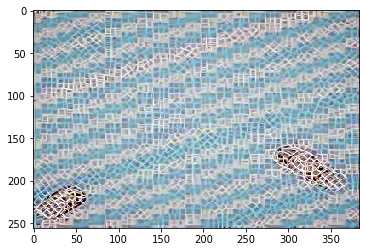

In [23]:
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))